<a href="https://colab.research.google.com/github/PiehTVH/MLflow-Dagshub/blob/main/Breast-Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mlflow dagshub optuna

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import warnings
warnings.filterwarnings('ignore')

import optuna

In [ ]:
df = pd.read_csv("/content/breast-cancer.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# EDA and preprocessing

In [ ]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]

print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 31
Discrete feature Count 0
Continuous feature Count 31
Categorical feature Count 1


In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,569.0,NaN,NaN,NaN,30371831.432337,125020585.612224,8670.0,869218.0,906024.0,8813129.0,911320502.0
diagnosis,569,2,B,357,NaN,NaN,NaN,NaN,NaN,NaN,NaN
radius_mean,569.0,NaN,NaN,NaN,14.127292,3.524049,6.981,11.7,13.37,15.78,28.11
texture_mean,569.0,NaN,NaN,NaN,19.289649,4.301036,9.71,16.17,18.84,21.8,39.28
perimeter_mean,569.0,NaN,NaN,NaN,91.969033,24.298981,43.79,75.17,86.24,104.1,188.5
area_mean,569.0,NaN,NaN,NaN,654.889104,351.914129,143.5,420.3,551.1,782.7,2501.0
smoothness_mean,569.0,NaN,NaN,NaN,0.09636,0.014064,0.05263,0.08637,0.09587,0.1053,0.1634
compactness_mean,569.0,NaN,NaN,NaN,0.104341,0.052813,0.01938,0.06492,0.09263,0.1304,0.3454
concavity_mean,569.0,NaN,NaN,NaN,0.088799,0.07972,0.0,0.02956,0.06154,0.1307,0.4268
concave points_mean,569.0,NaN,NaN,NaN,0.048919,0.038803,0.0,0.02031,0.0335,0.074,0.2012


In [ ]:
df.isnull().sum()

,0
id,0
diagnosis,0
radius_mean,0
texture_mean,0
perimeter_mean,0
area_mean,0
smoothness_mean,0
compactness_mean,0
concavity_mean,0
concave points_mean,0


In [ ]:
# corr_relation = df.corr()
# plt.figure(figsize=(15,15))
# sns.heatmap(corr_relation, annot=True)

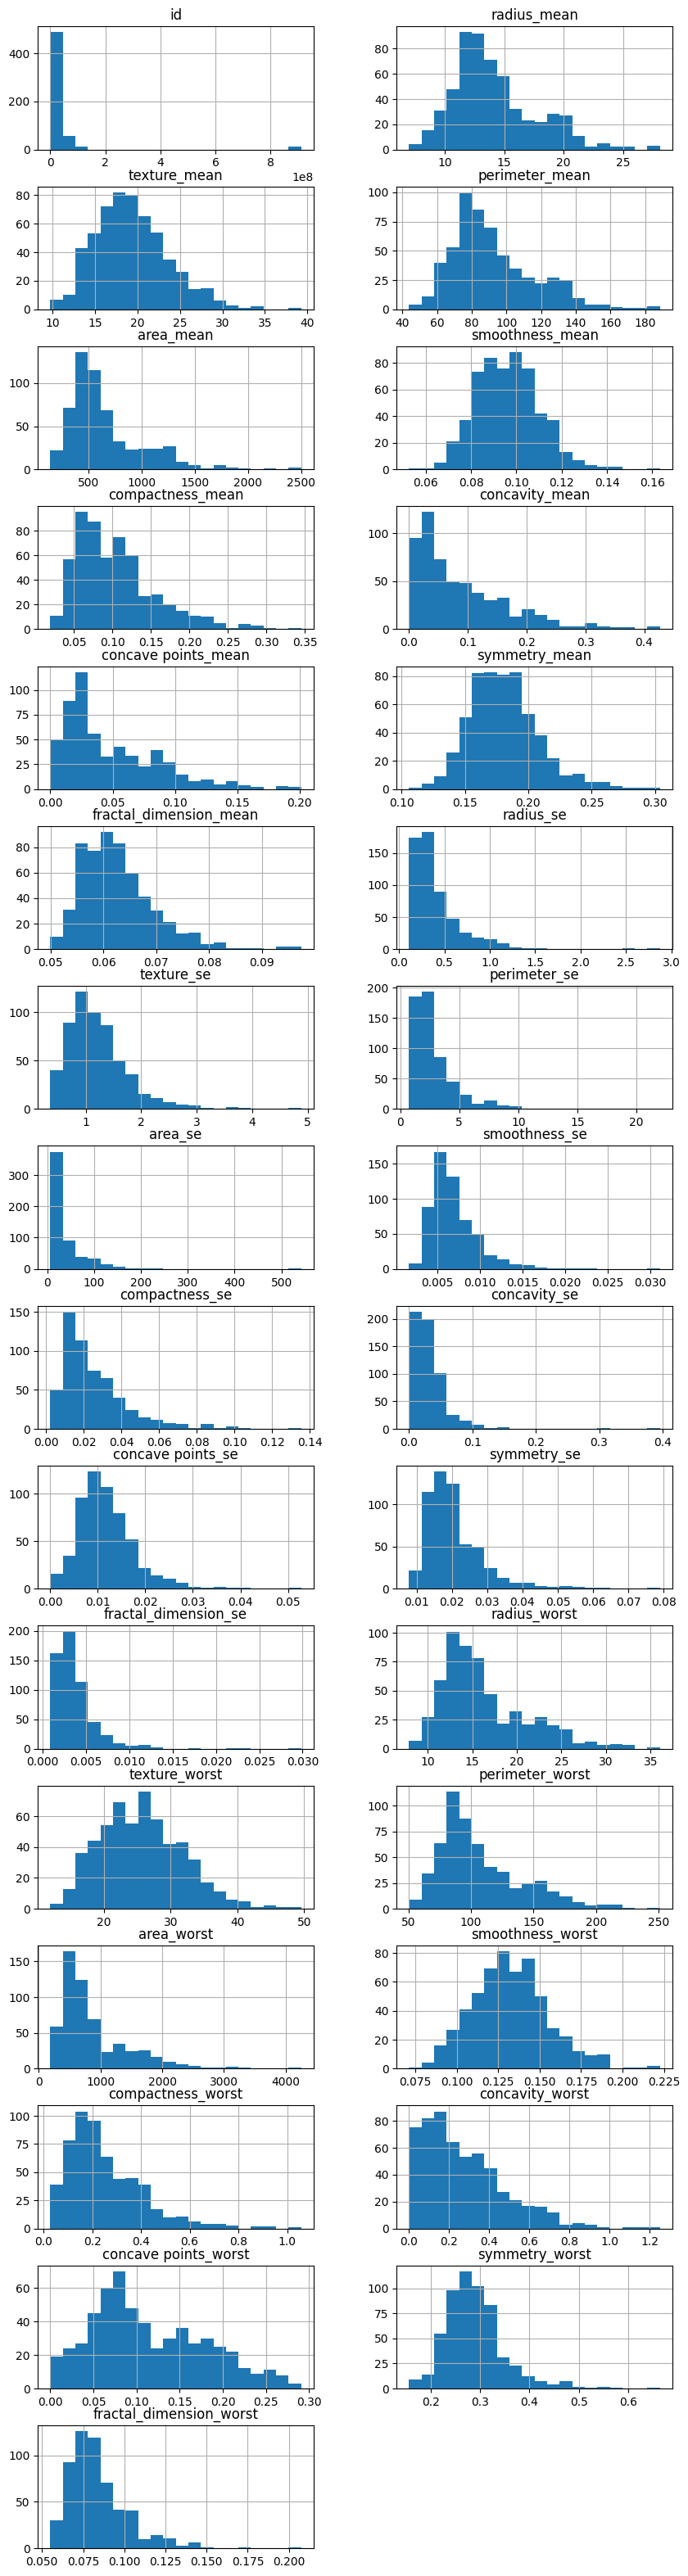

In [ ]:
df.hist(figsize=(10, 40), bins=20, layout=(16, 2))
plt.show()

In [ ]:
categorical_feature

['diagnosis']

In [ ]:
df.diagnosis.value_counts()

,count
diagnosis,
B,357
M,212


In [ ]:
df.replace({"M": 0, "B": 1}, inplace=True)

In [ ]:
df = df.iloc[:,1:]
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<Axes: >

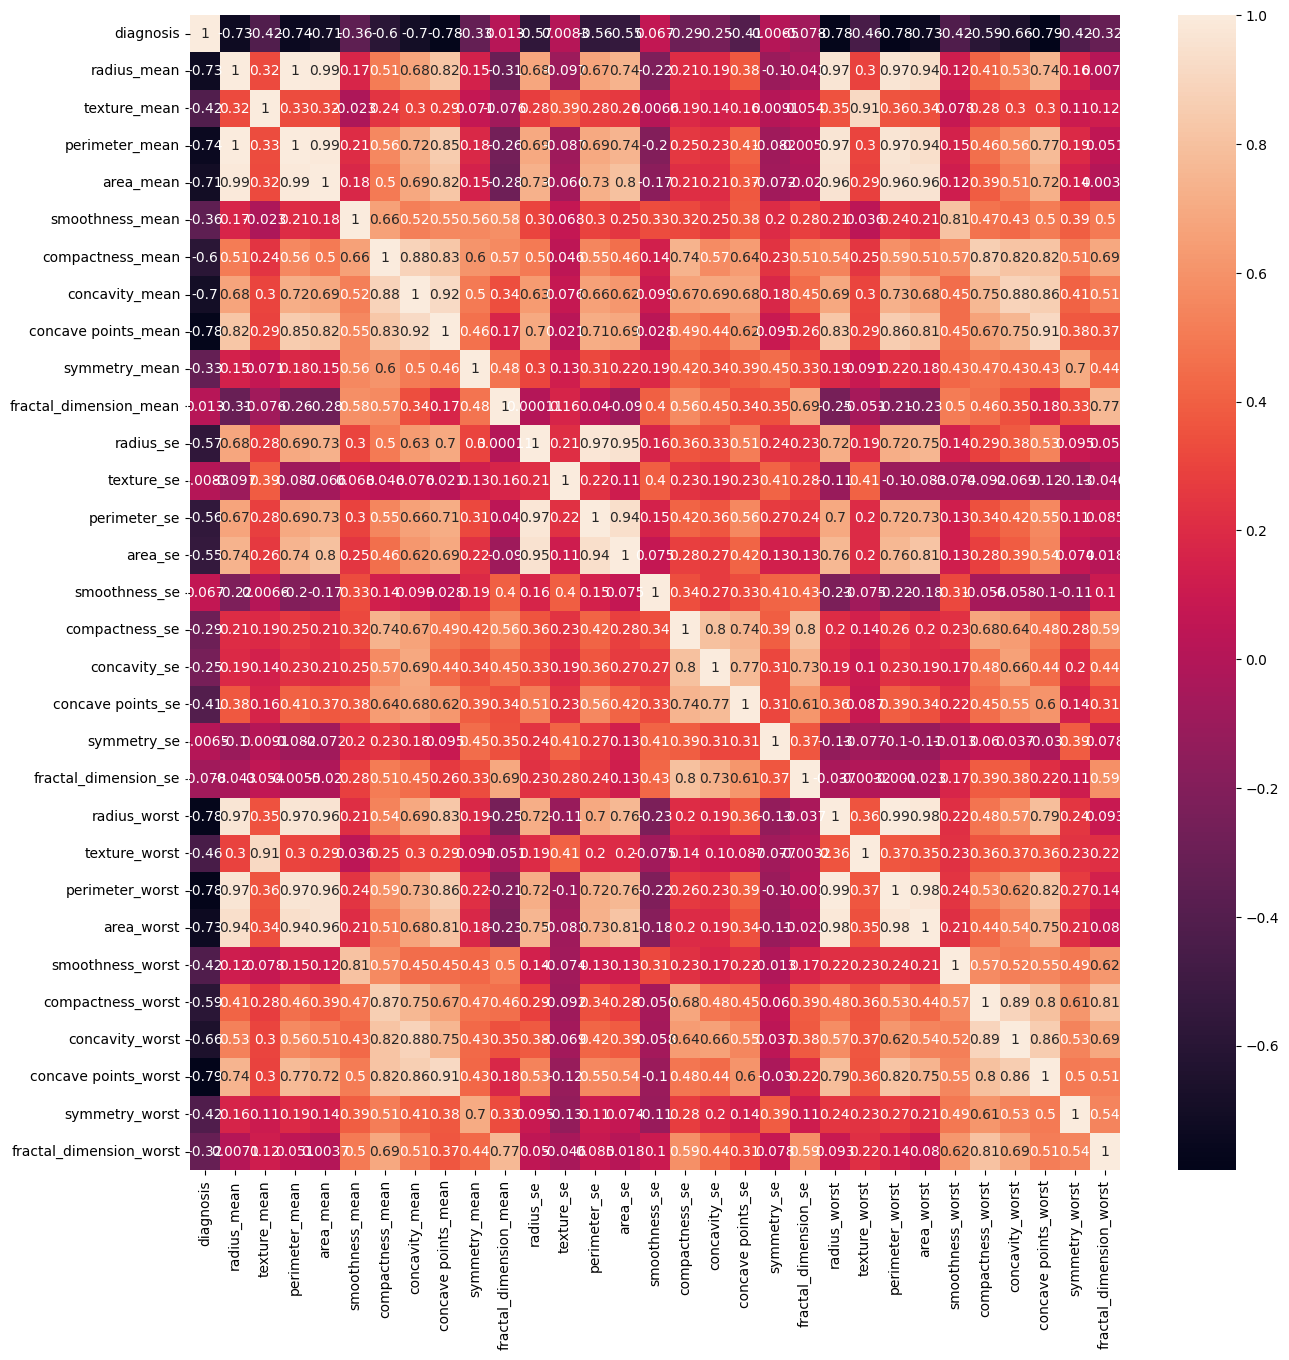

In [ ]:
corr_relation = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_relation, annot=True)

In [ ]:
x, y = df.iloc[:, 1:],df.iloc[:, 0]
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2)

# Training

In [ ]:
import mlflow
import mlflow.sklearn
import dagshub
dagshub.init("mlflow-S3E11", "hiep200326", mlflow=True)

Initialized MLflow to track repo "hiep200326/mlflow-S3E11"

Repository hiep200326/mlflow-S3E11 initialized!

In [ ]:
# mlflow.set_tracking_uri('https://dagshub.com/hiep200326/MLflow_Optuna.mlflow')
mlflow.set_tracking_uri('https://dagshub.com/hiep200326/mlflow-S3E11.mlflow')

In [ ]:
ext = ExtraTreesClassifier()

def mlflow_callback(study: optuna.Study, trial: optuna.Trial):
    mlflow.set_experiment("ExtraTrees-2")
    trial_value = trial.value if trial.value is not None else float("nan")
    with mlflow.start_run(run_name=str(trial.number)):
        mlflow.log_params(trial.params)
        mlflow.log_metrics({"accuracy": trial_value})

def objective(trial: optuna.Trial):

    param = {
        "objective": "binary",
        "n_estimators": trial.suggest_int("n_estimators", 50,500),
        "max_depth": trial.suggest_int("max_depth",3,7),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.001,1)
    }

    ext.fit(x_train,y_train)
    preds = ext.predict(x_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
# study.optimize(objective,n_trials=100)
study.optimize(objective,n_trials=50,callbacks=[mlflow_callback])

[I 2024-10-25 09:30:38,622] A new study created in memory with name: no-name-b7faa247-5bd0-41a4-abda-3ca59b25b3c8
[I 2024-10-25 09:30:39,121] Trial 0 finished with value: 0.9473684210526315 and parameters: {'n_estimators': 325, 'max_depth': 4, 'learning_rate': 0.9143119418922889}. Best is trial 0 with value: 0.9473684210526315.
2024/10/25 09:30:39 INFO mlflow.tracking.fluent: Experiment with name 'ExtraTrees-2' does not exist. Creating a new experiment.
2024/10/25 09:30:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 0 at: https://dagshub.com/hiep200326/mlflow-S3E11.mlflow/#/experiments/0/runs/af79666dc5f948d0a03e3be4da8b3513.
2024/10/25 09:30:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/hiep200326/mlflow-S3E11.mlflow/#/experiments/0.
[I 2024-10-25 09:30:42,847] Trial 1 finished with value: 0.9649122807017544 and parameters: {'n_estimators': 148, 'max_depth': 6, 'learning_rate': 0.12305221658292968}. Best is trial 1 with value

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.9649122807017544
  Params: 
    n_estimators: 148
    max_depth: 6
    learning_rate: 0.12305221658292968


In [ ]:
from mlflow.tracking import MlflowClient
MLFLOW_TRACKING_URI = "https://dagshub.com/hiep200326/mlflow-S3E11.mlflow"
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [ ]:
# experiment = client.get_experiment(experiment_id=1)
experiment = client.get_experiment_by_name("ExtraTrees-2")
print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

Name: ExtraTrees-2
Experiment_id: 0
Artifact Location: mlflow-artifacts:/d3cf8687a73a42bca5116f9af5a9041c
Tags: {}
Lifecycle_stage: active


In [ ]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids=['0'],
    filter_string="metrics.accuracy > 0.93",
    max_results=5,
    order_by=["metrics.accuracy DESC"]
)

In [ ]:
for run in runs:
    print(f"run id: {run.info.run_id}, accuracy: {run.data.metrics['accuracy']:.4f},params: {run.data.params}" )

run id: 483f5a0d35e842faab51f2f829dbbd8a, accuracy: 0.9649,params: {'n_estimators': '228', 'max_depth': '5', 'learning_rate': '0.30879428882889937'}
run id: ebc967bb0ce44b8bb55d2110fa541f62, accuracy: 0.9649,params: {'n_estimators': '78', 'max_depth': '5', 'learning_rate': '0.2148723809147807'}
run id: a4236ac08d124b1cb98dad168099ce80, accuracy: 0.9649,params: {'n_estimators': '181', 'max_depth': '7', 'learning_rate': '0.27966908689244707'}
run id: 1f0d9a4da2c8466d8cbcc668caf5261a, accuracy: 0.9649,params: {'n_estimators': '290', 'max_depth': '4', 'learning_rate': '0.8041609490766601'}
run id: af4b69f44cab413d9bbf0448e503b0df, accuracy: 0.9649,params: {'n_estimators': '85', 'max_depth': '6', 'learning_rate': '0.5580615502955186'}
